EE 250 FINAL PROJECT  
Eric Zhong and Natasha Lal  
This notebook was for development purposes only. Refer to standalone python scripts for final code.  

In [35]:
#Import Libraries
import scipy
import matplotlib.pyplot as plt
import numpy as np
import wave
import wavio
import soundfile as sf
from pydub import AudioSegment
from pydub.playback import play
import random
import time
import os
import sys

In [ ]:
#Test Waveform Generation
rate = 44100
T = 3
f = 440
t = np.linspace(0, T, T*rate, endpoint=False)
x = np.sin(2*np.pi*f*t)
y = np.sin(2*np.pi*f*t)

wavio.write("test.wav", 100*x, rate, sampwidth=3)

[16298, 16941, 17578, 17444, 16804]
[19599, 18816, 18987, 19138, 19738, 18325]
MARK W REDEKOPP~


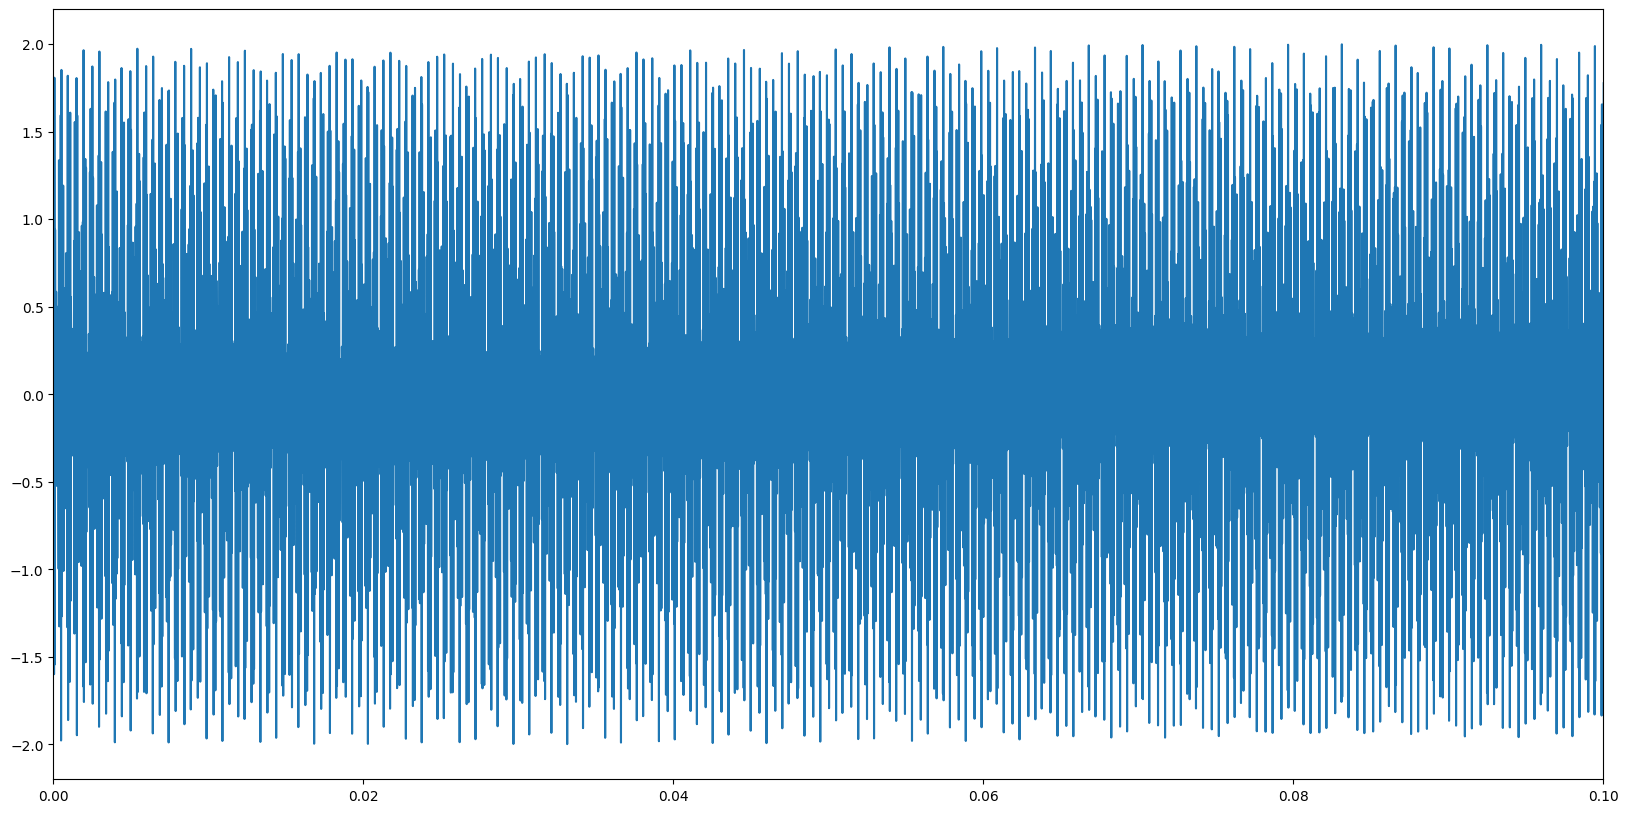

In [88]:
#Message Waveform Generation
message = 'MARK W REDEKOPP'
key = 100
message = message.upper()
random.seed(key)

lower_fbound = 16000
mid = 18000
upper_fbound = 20000
char_lookup = [['A','B','C','D','E','F'], 
               ['G','H','I','J','K','L'], 
               ['M','N','O','P','Q','R'], 
               ['S','T','U','V','W','X'],
               ['Y','Z',' ',' ',' ','~']]

window = 100
lowFreqs = list()
for i in range(5):
    while True:
        temp = random.randint(lower_fbound, mid-window)
        flag = True
        for f in lowFreqs:
            if(temp >= f-window and temp <= f+window):
                flag = False
        if flag:
            break
    lowFreqs.append(temp)

highFreqs = list()
for i in range (6):
    while True:
        temp = random.randint(mid+window, upper_fbound)
        flag = True
        for f in lowFreqs:
            if(temp >= f-window and temp <= f+window):
                flag = False
        if flag:
            break
    highFreqs.append(temp)

print(lowFreqs)
print(highFreqs)

pad = 15-len(message)
message += '~'
while pad > 0:
    message += char_lookup[random.randint(0,4)][random.randint(0,5)]
    pad -= 1
print(message)

toneFreqs = list()
for i in range(len(message)):
    char = message[i]
    freq = tuple()
    if char == '~':
        freq = (lowFreqs[4], highFreqs[5])
    elif char == ' ':
        freq = (lowFreqs[4], highFreqs[2])
    else:
        freq = (lowFreqs[int((ord(char)-ord('A'))/6)], highFreqs[(ord(char)-ord('A'))%6])
    toneFreqs.append(freq)


tones = list()
x = np.arange(0, 0.25, (1/44100))
for t in toneFreqs:
    tones.append((np.sin(2*np.pi*x * t[0]) + np.sin(2*np.pi*x * t[1])))
output = np.concatenate(tones)


x = np.arange(0, 4, (1/44100))
plt.figure(figsize=(20, 10))
plt.plot(x, output)
plt.xlim(0, 0.1)

wavio.write("output.wav", output, 44100, sampwidth=4)


#sound1 = AudioSegment.from_file("output.wav", format="wav")
#sound2 = AudioSegment.from_file("rickroll.wav", format="wav")
#combined = sound1.overlay(sound2)
#combined.export("combined.wav", format='wav')


In [90]:
#Decode Message
MAX_FRQ = 20000
SLICE_SIZE = 0.25 #seconds
WINDOW_SIZE = 0.25 #seconds

key = 1000
random.seed(key)

lower_fbound = 16000
mid = 18000
upper_fbound = 20000
char_lookup = [['A','B','C','D','E','F'], 
               ['G','H','I','J','K','L'], 
               ['M','N','O','P','Q','R'], 
               ['S','T','U','V','W','X'],
               ['Y','Z',' ',' ',' ','~']]

window = 100
lowFreqs = list()
for i in range(5):
    while True:
        temp = random.randint(lower_fbound, mid-window)
        flag = True
        for f in lowFreqs:
            if(temp >= f-window and temp <= f+window):
                flag = False
        if flag:
            break
    lowFreqs.append(temp)

highFreqs = list()
for i in range (6):
    while True:
        temp = random.randint(mid+window, upper_fbound)
        flag = True
        for f in lowFreqs:
            if(temp >= f-window and temp <= f+window):
                flag = False
        if flag:
            break
    highFreqs.append(temp)

def get_max_frq(frq, fft):
    max_frq = 0
    max_fft = 0
    for idx in range(len(fft)):
        if abs(fft[idx]) > max_fft:
            max_fft = abs(fft[idx])
            max_frq = frq[idx]
    return max_frq

def get_peak_frqs(frq, fft):
    #TODO: implement an algorithm to find the two maximum values in a given array

    #get the high and low frequency by splitting it in the middle (1000Hz)
    low = int(len(frq)*(4/5))
    bound = int(len(frq)*(9/10))
    low_frq = frq[low:bound]
    low_frq_fft = fft[low:bound]
    high_frq = frq[bound:]
    high_frq_fft = fft[bound:]

    #spliting the FFT to high and low frequencies
    return (get_max_frq(low_frq, low_frq_fft), get_max_frq(high_frq, high_frq_fft))

def get_char_from_frq(lower_frq, higher_frq):
    #TODO: given a lower frequency and higher frequency pair
    #      return the corresponding key otherwise return '?' if no match is found
    low_index = -1; high_index= -1

    for i in range(len(lowFreqs)):
        if (lower_frq < lowFreqs[i]+10) and (lower_frq > lowFreqs[i]-10):
            low_index = i
            break
    
    for i in range(len(highFreqs)):
        if (higher_frq < highFreqs[i]+10) and (higher_frq > highFreqs[i]-10):
            high_index = i
            break

    print(lower_frq, higher_frq)
    if(low_index == -1 or high_index == -1): return '?'
    return char_lookup[low_index][high_index]



file = "output.wav"
audio = AudioSegment.from_wav(file)

sample_count = audio.frame_count()
sample_rate = audio.frame_rate
samples = audio.get_array_of_samples()

period = 1/sample_rate                     #the period of each sample
duration = sample_count/sample_rate         #length of full audio in seconds

slice_sample_size = int(SLICE_SIZE*sample_rate)   #get the number of elements expected for [SLICE_SIZE] seconds

n = slice_sample_size                            #n is the number of elements in the slice

#generating the frequency spectrum
k = np.arange(n)                                #k is an array from 0 to [n] with a step of 1
slice_duration = n/sample_rate                   #slice_duration is the length of time the sample slice is (seconds)
frq = k/slice_duration                          #generate the frequencies by dividing every element of k by slice_duration

max_frq_idx = int(MAX_FRQ*slice_duration)       #get the index of the maximum frequency (2000)
frq = frq[range(max_frq_idx)]                   #truncate the frequency array so it goes from 0 to 2000 Hz

start_index = 0                                 #set the starting index at 0
end_index = start_index + slice_sample_size      #find the ending index for the slice
output = ''

print()
i = 1
while end_index < len(samples):
    #print("Sample {}:".format(i))
    i += 1

    #TODO: grab the sample slice and perform FFT on it
    sample_slice = samples[start_index: end_index]
    slice_fft = np.fft.fft(sample_slice)/n
    
    #TODO: truncate the FFT to 0 to 2000 Hz
    slice_fft = slice_fft[range(max_frq_idx)]

    #TODO: calculate the locations of the upper and lower FFT peak using get_peak_frqs()
    peak_frqs = get_peak_frqs(frq, slice_fft)

    #TODO: print the values and find the number that corresponds to the numbers
    val = get_char_from_frq(peak_frqs[0], peak_frqs[1])
    output += val
    print(val)

    #Incrementing the start and end window for FFT analysis
    start_index += int(WINDOW_SIZE*sample_rate)
    end_index = start_index + slice_sample_size

print("Program completed")
print("Decoded input: " + str(output))


17576.0 19600.0
M
16296.0 19600.0
A
17576.0 18324.0
R
16940.0 19740.0
K
16804.0 18988.0
 
17444.0 19740.0
W
16804.0 18988.0
 
17576.0 18324.0
R
16300.0 19740.0
E
16296.0 19140.0
D
16300.0 19740.0
E
16940.0 19740.0
K
17576.0 18988.0
O
17576.0 19140.0
P
17576.0 19140.0
P
Program completed
Decoded input: MARK W REDEKOPP


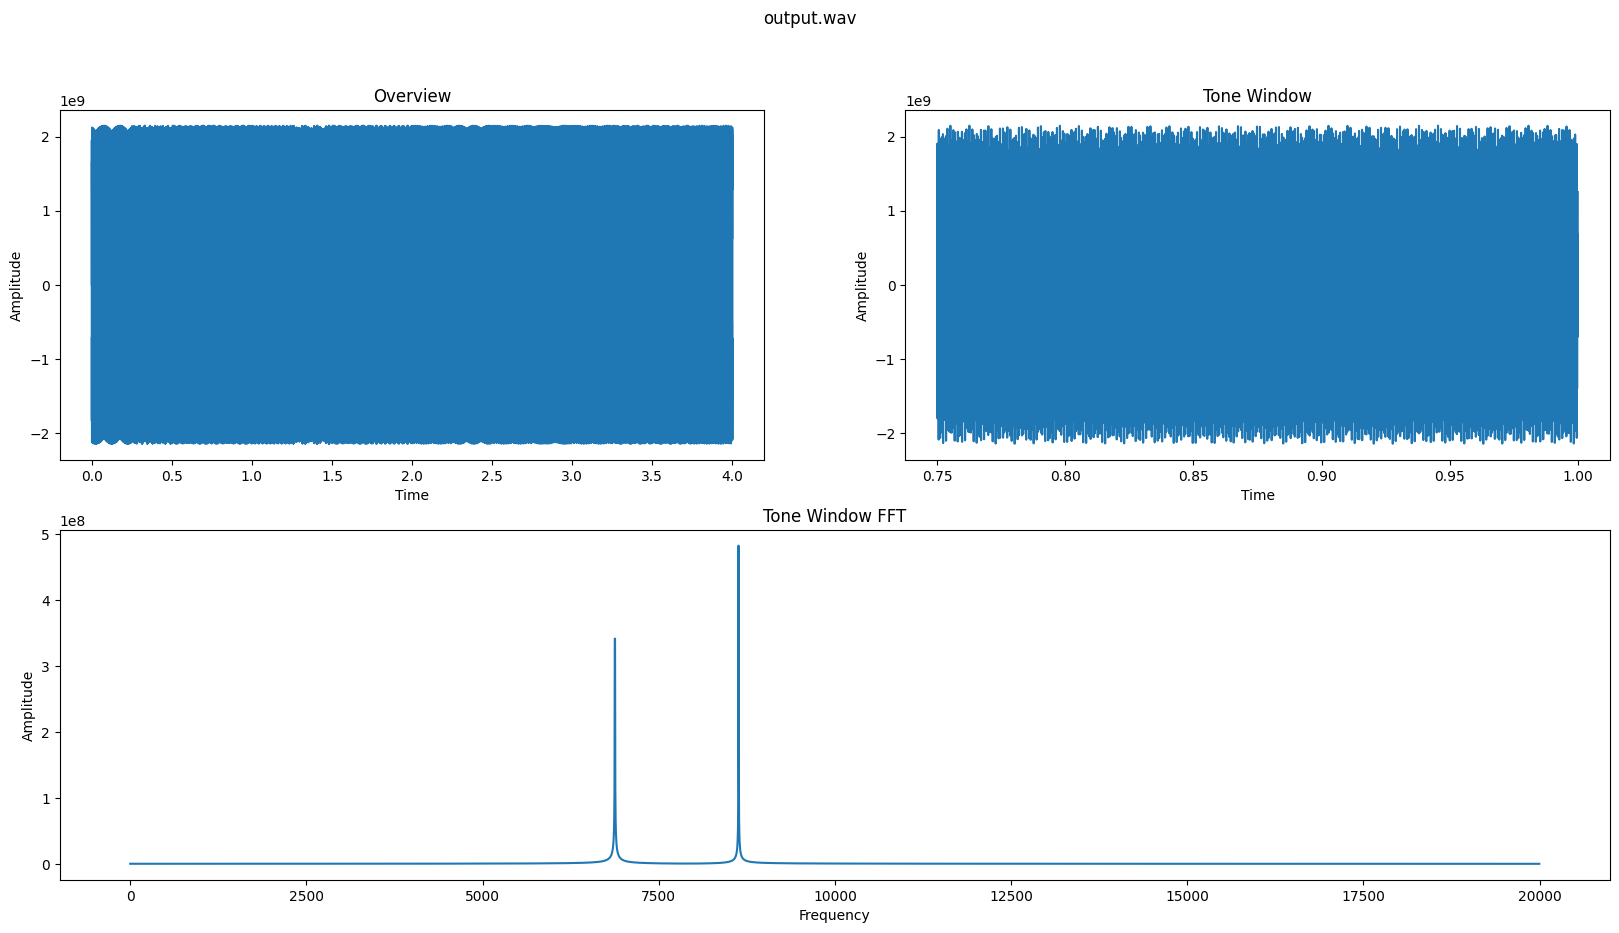

In [91]:
#Audio Analysis
file = "output.wav"
audio = AudioSegment.from_wav(str(file))
start_time = 0.75
MAX_FRQ = 20000
SLICE_SIZE = 0.25

sample_count = audio.frame_count()
sample_rate = audio.frame_rate

"""***********************FULL SAMPLE PLOT**************************"""
samples = audio.get_array_of_samples()
period = 1/sample_rate                  #the period of each sample
duration = sample_count/sample_rate     #length of full audio in seconds
time = np.arange(0, duration, period)   #generate a array of time values from 0 to [duration] with step of [period]

#TODO: Plot the full sample as a subplot (make sure to include labels)
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.plot(time, samples)
plt.title("Overview")
plt.xlabel("Time")
plt.ylabel("Amplitude")

"""***********************SAMPLE SLICE PLOT*************************"""
slice_frame_size = int(SLICE_SIZE*sample_rate)   #get the number of elements expected for [SLICE_SIZE] seconds
start_index = int(start_time*sample_rate)        #get the starting index for the given [start_time]
end_index = start_index + slice_frame_size      #find the ending index for the slice

time_slice = time[start_index: end_index]       #take a slice from the time array for the given start and end index 
sample_slice = samples[start_index: end_index]  #take a slice from the samples array for the given start and end index

#TODO: Plot the sample slice as a subplot (make sure to include labels)
plt.subplot(222)
plt.plot(time_slice, sample_slice)
plt.title("Tone Window")
plt.xlabel("Time")
plt.ylabel("Amplitude")

"""**********************SAMPLE SLICE FFT PLOT**********************"""
n = slice_frame_size                            #n is the number of elements in the slice

#generating the frequency spectrum
k = np.arange(n)                                #k is an array from 0 to [n] with a step of 1
slice_duration = n/sample_rate                   #slice_duration is the length of time the sample slice is (seconds)
frq = k/slice_duration                          #generate the frequencies by dividing every element of k by slice_duration

sample_slice_fft = np.fft.fft(sample_slice)/n   #perform the fourier transform on the sample_slice and normalize by dividing by n

max_frq_idx = int(MAX_FRQ*slice_duration)       #get the index of the maximum frequency (2000)
frq = frq[range(max_frq_idx)]                   #truncate the frequency array so it goes from 0 to 2000 Hz
sample_slice_fft = sample_slice_fft[range(max_frq_idx)]     #truncate the sample slice fft array so it goes from 0 to 2000 Hz

#TODO: Plot the frequency spectrum as a subplot (make sure to include labels)
plt.subplot(212)
plt.plot(frq, abs(sample_slice_fft))
plt.title("Tone Window FFT")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")

plt.suptitle(file)
plt.show()

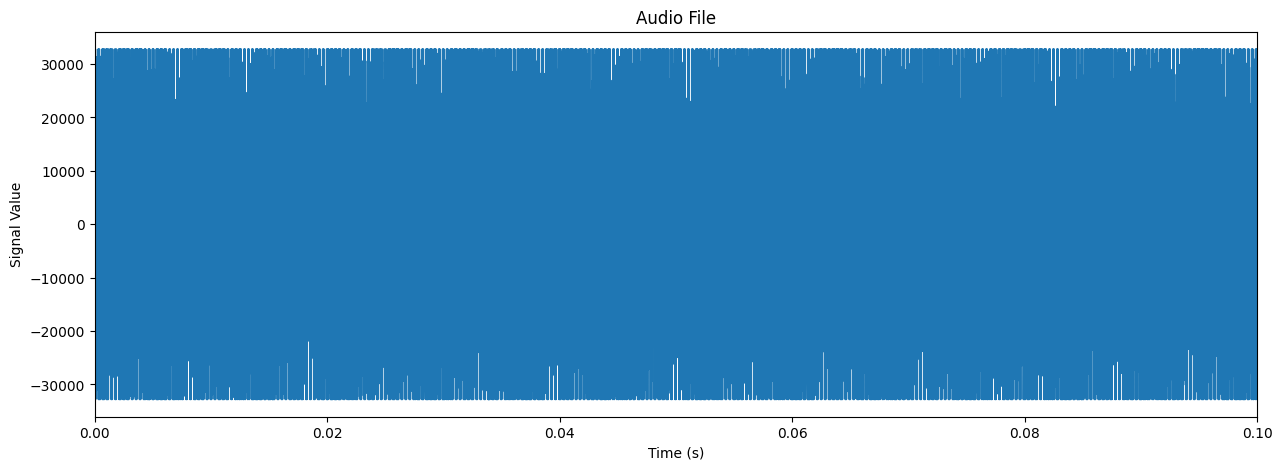

In [60]:
#Waveform Reading and Visualization
file = 'output.wav'
wav_obj = wave.open(file, 'rb')
sample_freq = wav_obj.getframerate()
n_samples = wav_obj.getnframes()
t_audio = n_samples/sample_freq
n_channels = wav_obj.getnchannels()

signal_wave = wav_obj.readframes(n_samples)
signal_array = np.frombuffer(signal_wave, dtype=np.int16)
channel = signal_array

times = np.linspace(0, n_samples/sample_freq, num = len(signal_array))

plt.figure(figsize=(15,5))
plt.plot(times, channel)
plt.title('Audio File')
plt.xlabel('Time (s)')
plt.ylabel('Signal Value')
plt.xlim(0, 0.1)
plt.show()

In [ ]:
#Plotting the Frequency Spectrum
plt.figure(figsize=(15,5))
plt.specgram(channel, Fs=sample_freq, vmin=-20, vmax=50)
plt.title('Frequency Spectrum')
plt.ylabel('Freqeuency (Hz)')
plt.xlabel('Time (s)')
plt.xlim(0, t_audio)
plt.ylim(0, 1000)
plt.colorbar()
plt.show()